## Анализ оттока клиентов банка "Метанпром"

Заказчик — региональный банк "Метанпром". Нужно проанализировать клиентов банка и выделить сегменты клиентов, которые склонны уходить из банка. Входные данные — это данные о клиентах банка расположеном в Ярославле и областных городах: Ростов Великий и Рыбинск.

В нашем распоряжении один датасет `bank_scrooge.csv`, он содержит данные о клиентах банка «Метанпром»:

- `userid` --  идентификатор пользователя
- `score` -- баллы кредитного скоринга
- `city` -- город
- `gender` -- пол
- `age` -- возраст
- `equity` -- количество баллов собственности
- `balance` -- баланс на счёте
- `products` -- количество продуктов, которыми пользуется клиент
- `credit_card` -- есть ли кредитная карта
- `last_activity` -- активный клиент
- `est_salary` -- оценочный доход клиента
- `сhurn` -- признак оттока

**Цель исследования:** Разобраться в причинах оттока клиентов банка "Метанпром" и выделить сегменты клиентов, которые склонны уходить из банка.

**Ход исследования:** 
- Выполним предобработку данных
- Исследуем данные о клиентах
- Проверим статистические гипотезы
- Выделим сегменты клиентов на основе значимых признаков

## Шаг 1. Загрузим данные и подготовим их к анализу

Добавим необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
from phik import phik_matrix
from scipy import stats

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в переменную data.

In [2]:
try:
    data = pd.read_csv('/datasets/bank_scrooge.csv',sep=',')
except:
    data = pd.read_csv('/Users/a0000/Documents/Analitic/Graduation_project/project/bank_scrooge.csv',sep=',')

Выведем первые 5 строк датафрейма

In [3]:
data.head(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Изучим общую информацию

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


## Шаг 2. Выполним предобработку данных

### Приведем названия в колонках к нижнему регистру

In [5]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

### Обработаем пропуски 

In [6]:
data.isna().sum()

userid              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

Пропуски в столбцах age исключим 

In [7]:
data = data.dropna(subset=['age'])

Пропуски в столбцах balance оставим как есть

### Исправим типы данных в колонках: 

In [8]:
data.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [9]:
data['credit_card'] = data['credit_card'].astype('bool')

In [10]:
data['last_activity'] = data['last_activity'].astype('bool')

In [11]:
data['churn'] = data['churn'].astype('bool')

In [12]:
data['score'] = data['score'].astype(int)

In [13]:
data['age'] = data['age'].astype(int)

### Определим есть ли в данных  дубликаты

In [14]:
data[data.duplicated()]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


**Промежуточный вывод:** Явных дубликатов в данных не обнаружено

### Проверим неявные дубликаты

In [15]:
duplicates_userid_and_age = data[data.duplicated(subset=['userid', 'age'])]

In [16]:
duplicates_userid_and_age

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3817,211130,918,Рыбинск,Ж,55,0,NaN,2,True,True,244202.04,False
5197,155765,923,Рыбинск,М,30,0,NaN,1,True,True,120296.60,False
6786,163207,838,Ярославль,Ж,42,4,652776.60,2,True,True,97545.36,False
8364,148826,909,Рыбинск,Ж,32,0,NaN,3,True,False,28843.54,False
8497,227795,839,Ярославль,М,34,2,326593.14,2,True,False,103314.92,False


In [17]:
for i in duplicates_userid_and_age['userid']:
    print(data[data['userid'] == i])

      userid  score       city gender  age  equity    balance  products  \
1359  211130    833  Ярославль      М   55       3  1231184.9         4   
3817  211130    918    Рыбинск      Ж   55       0        NaN         2   

      credit_card  last_activity  est_salary  churn  
1359        False           True   187758.38   True  
3817         True           True   244202.04  False  
      userid  score       city gender  age  equity    balance  products  \
3274  155765    863  Ярославль      М   30       5  1036114.5         5   
5197  155765    923    Рыбинск      М   30       0        NaN         1   

      credit_card  last_activity  est_salary  churn  
3274         True           True    150744.5   True  
5197         True           True    120296.6  False  
      userid  score       city gender  age  equity    balance  products  \
3564  163207    853    Рыбинск      М   42       4  543839.62         1   
6786  163207    838  Ярославль      Ж   42       4  652776.60         2   

**Промежуточный вывод:** Мы имеем повторяющиеся значения в userid, но уникальным считается userid и city, город у нас разный, значит можем считать эти данные не дубликатами

### Определим есть ли аномальные значения

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   int64  
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   bool   
 9   last_activity  9974 non-null   bool   
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   bool   
dtypes: bool(3), float64(2), int64(5), object(2)
memory usage: 808.4+ KB


In [19]:
data[data['products'] == 0]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,False,False,25063.96,True


**Промежуточный вывод:** У пользователя 147837 нету ни одного продукта банка, это аномалия, исключим его

In [20]:
# Исключение пользователя с user_id 147837
data = data[data['products'] != 0]


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9973 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9973 non-null   int64  
 1   score          9973 non-null   int64  
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   int64  
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   bool   
 9   last_activity  9973 non-null   bool   
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   bool   
dtypes: bool(3), float64(2), int64(5), object(2)
memory usage: 808.4+ KB


## Шаг 3. Исследовательский анализ данных

### Посчитаем общий отток пользователей

In [22]:
round(data.churn.sum() / data.churn.count() * 100,2)

18.23

**Промежуточный вывод:** Общий отток пользователй составил 18.23% 

Создадим функцию для построения графиков с нормированной плотностью и stacked - гистограммой, в функцию передаем параметр по которому будем оценивать, определяем discreate как True или False и названия графиков

In [23]:
def plot_histograms(data, x_param, discreate_parametr, title_density, title_stacked):
    fig, (ax2, ax) = plt.subplots(1, 2, figsize=(17, 7))  # 1 ряд, 2 столбца

    # График с нормированной плотностью
    sns.histplot(
        data=data,
        hue='churn',
        x=x_param,
        stat='density',
        common_norm=False,
        ax=ax2,
        palette='flag',
        discrete=discreate_parametr
    )
    ax2.set_title(title_density)

    # График со stacked-гистограммой
    sns.histplot(
        data=data,
        x=x_param,
        hue='churn',
        multiple='stack',  # добавляем stacked-гистограмму
        stat='count',      # для оси Y используется 'count'
        ax=ax,
        palette='flag',
        discrete=discreate_parametr
    )
    ax.set_xlabel(x_param)
    ax.set_ylabel("Count")
    ax.set_title(title_stacked)

    plt.tight_layout()  # для улучшения расположения графиков
    plt.show()

# Пример вызова функции

### Вероятностный Анализ по категории баллы кредитного скоринга (`score`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


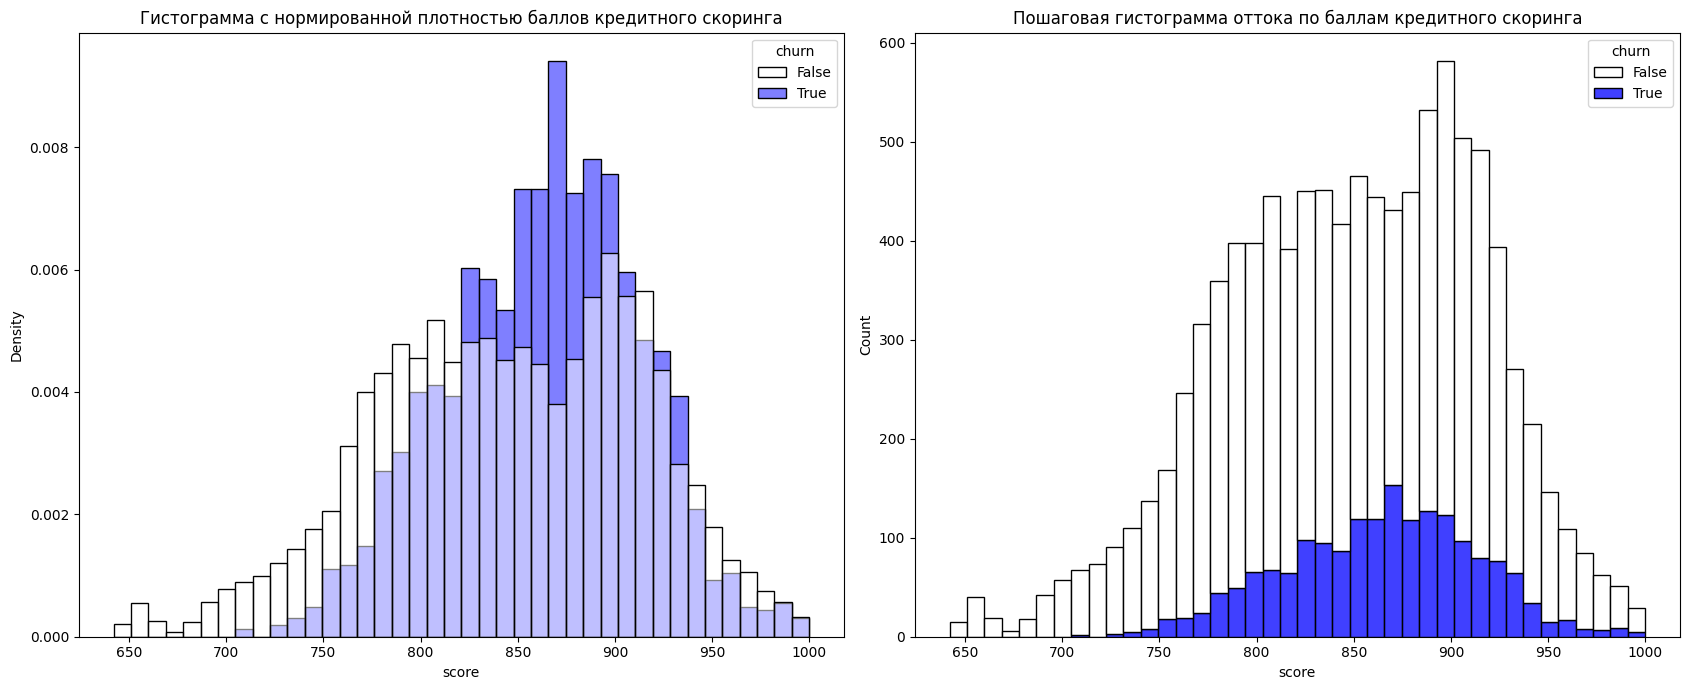

In [24]:
plot_histograms(data, x_param='score',discreate_parametr = False,\
                title_density="Гистограмма с нормированной плотностью баллов кредитного скоринга",\
                title_stacked="Пошаговая гистограмма оттока по баллам кредитного скоринга")

**Промежуточный вывод:** Для баллов кредитного скоринга высоко-отточные значения расположены примерно в пределах от 825 до 940 баллов

### Вероятностный Анализ по городу (`city`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


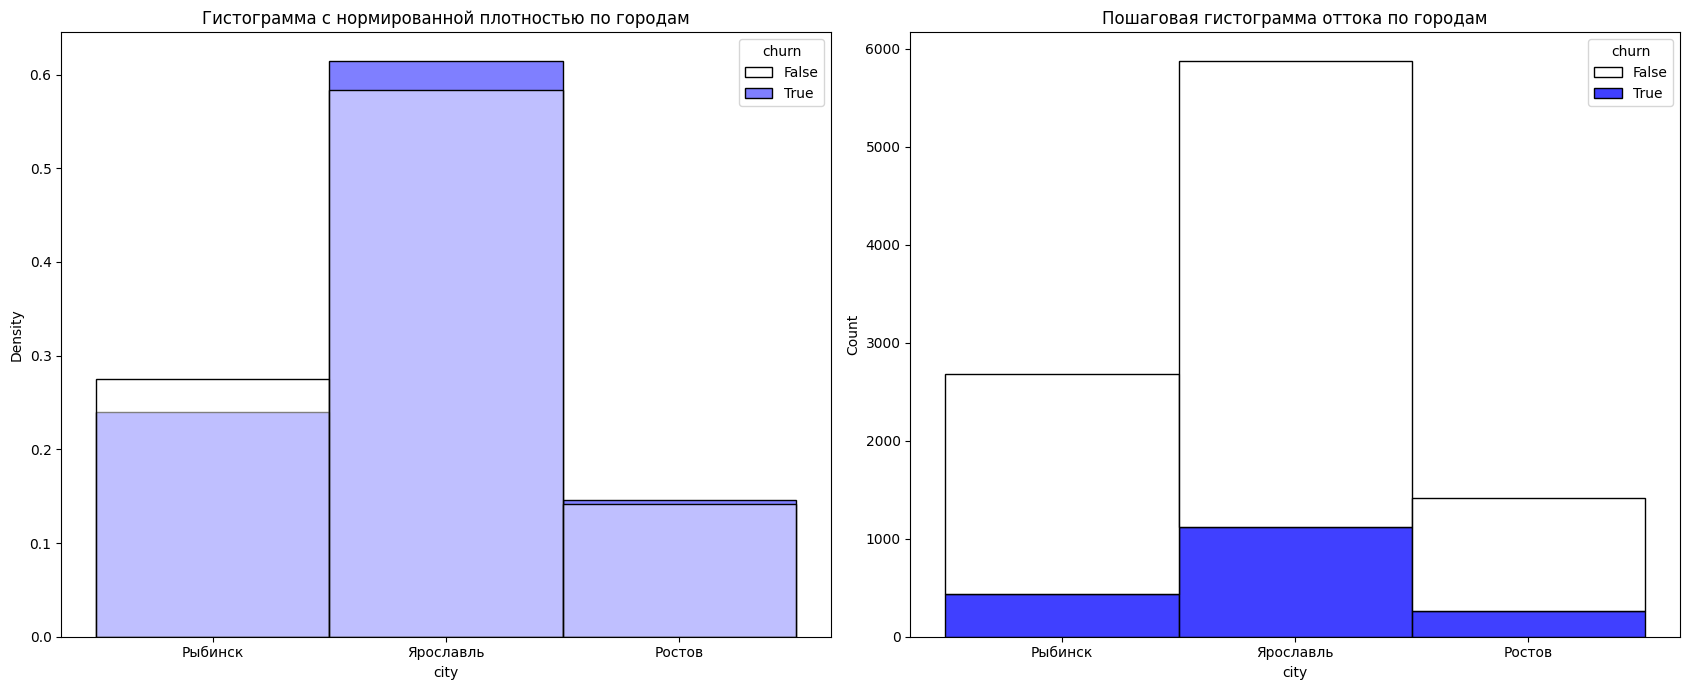

In [25]:
plot_histograms(data, x_param='city',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по городам",\
                title_stacked="Пошаговая гистограмма оттока по городам")

**Промежуточный вывод:** Вероятностный анализ показывает, что в городе Ярославоль более высокий отток пользователей, чем в остальных городах

### Вероятностный Aнализ по категории пола человека (`gender`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


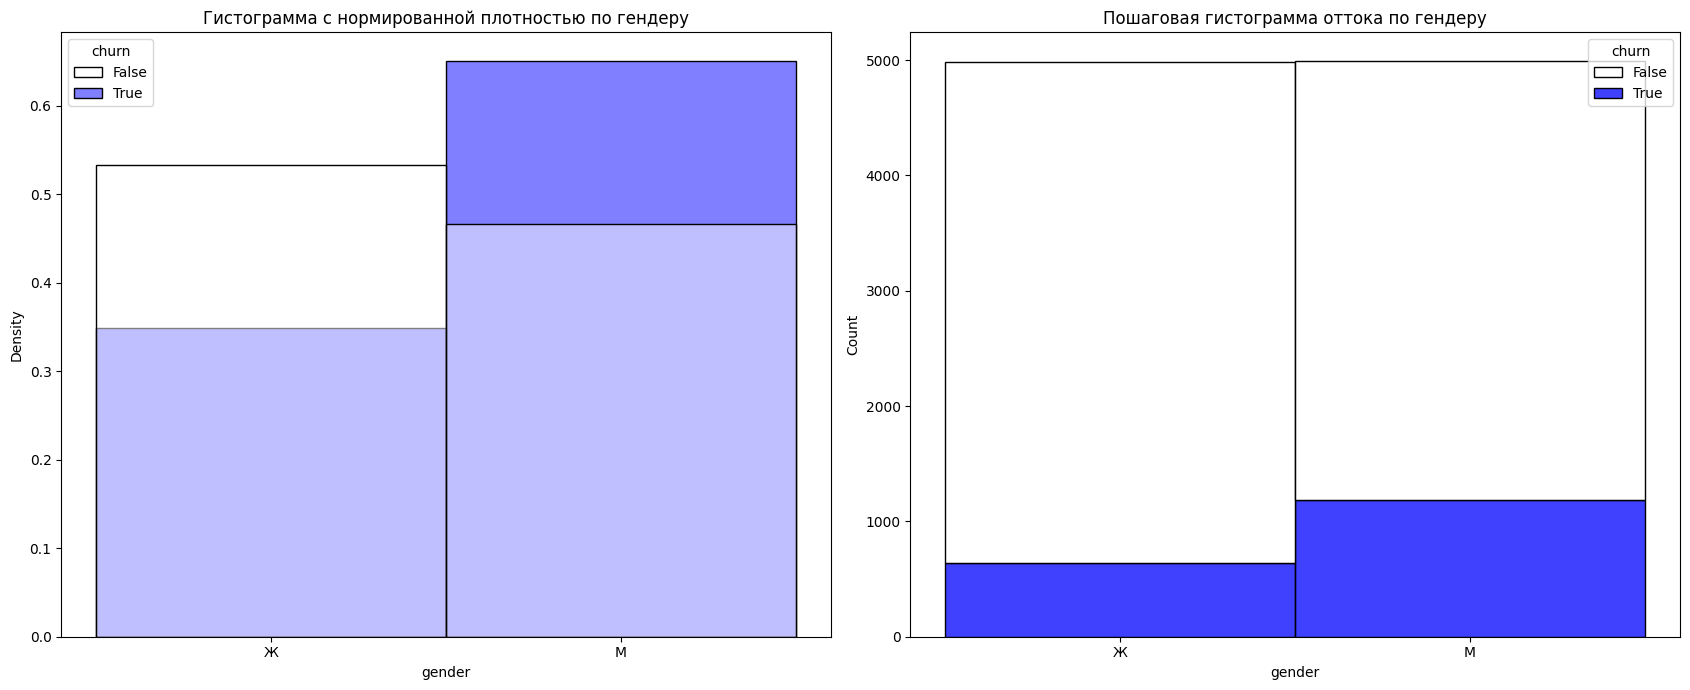

In [26]:
plot_histograms(data, x_param='gender',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по гендеру",\
                title_stacked="Пошаговая гистограмма оттока по гендеру")

**Промежуточный вывод:** Вероятностный анализ показывет, что мужчины больше склонны к оттоку

### Вероятностный Анализ по категори возраста (`age`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


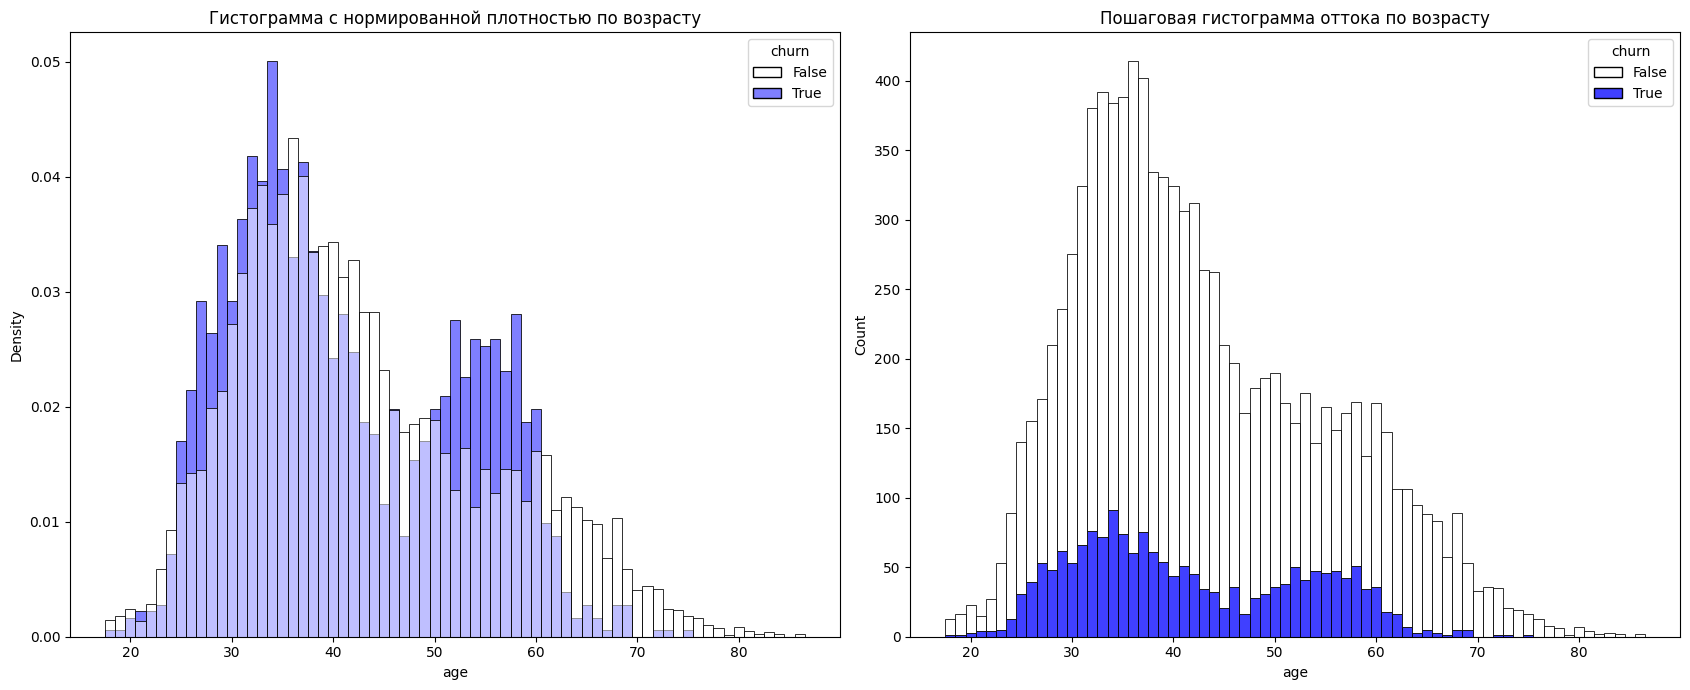

In [27]:
plot_histograms(data, x_param='age',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по возрасту",\
                title_stacked="Пошаговая гистограмма оттока по возрасту")

**Промежуточный вывод:** Вероятностный анализ показывет, что высоко-отточные значения возраста клиентов расположены в пределах от 25 до 35 лет и от 50 года до 60 лет

### Вероятностный Анализ по категории количества баллов собственности (`equity`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


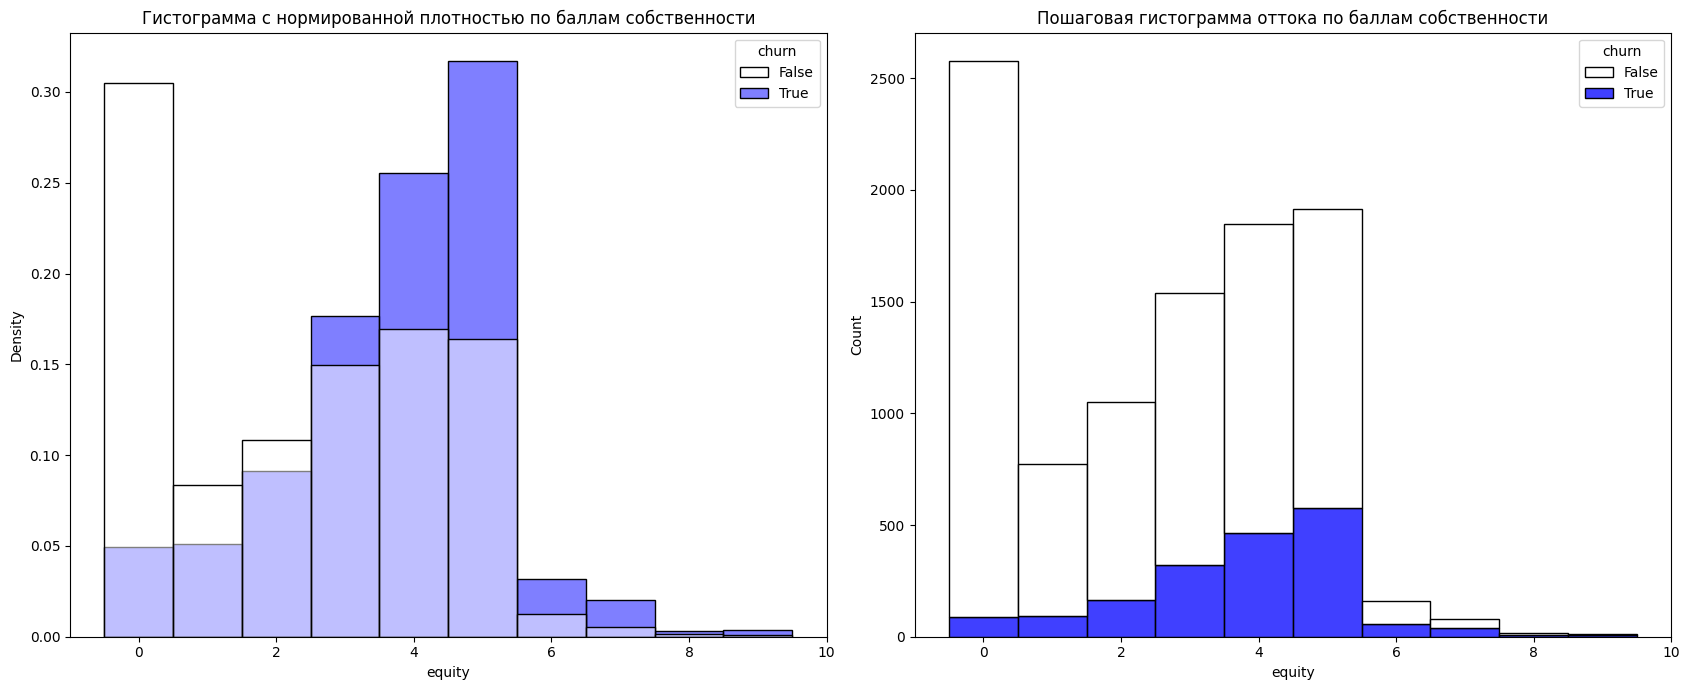

In [28]:
plot_histograms(data, x_param='equity',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по баллам собственности",\
                title_stacked="Пошаговая гистограмма оттока по баллам собственности")

**Промежуточный вывод:** Вероятностный анализ показывает, что высоко-отточные клиенты расположены в пределах от 3 до 7 баллов собственности 

### Вероятностный Aнализ по категории баланса человека (`balance`) 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


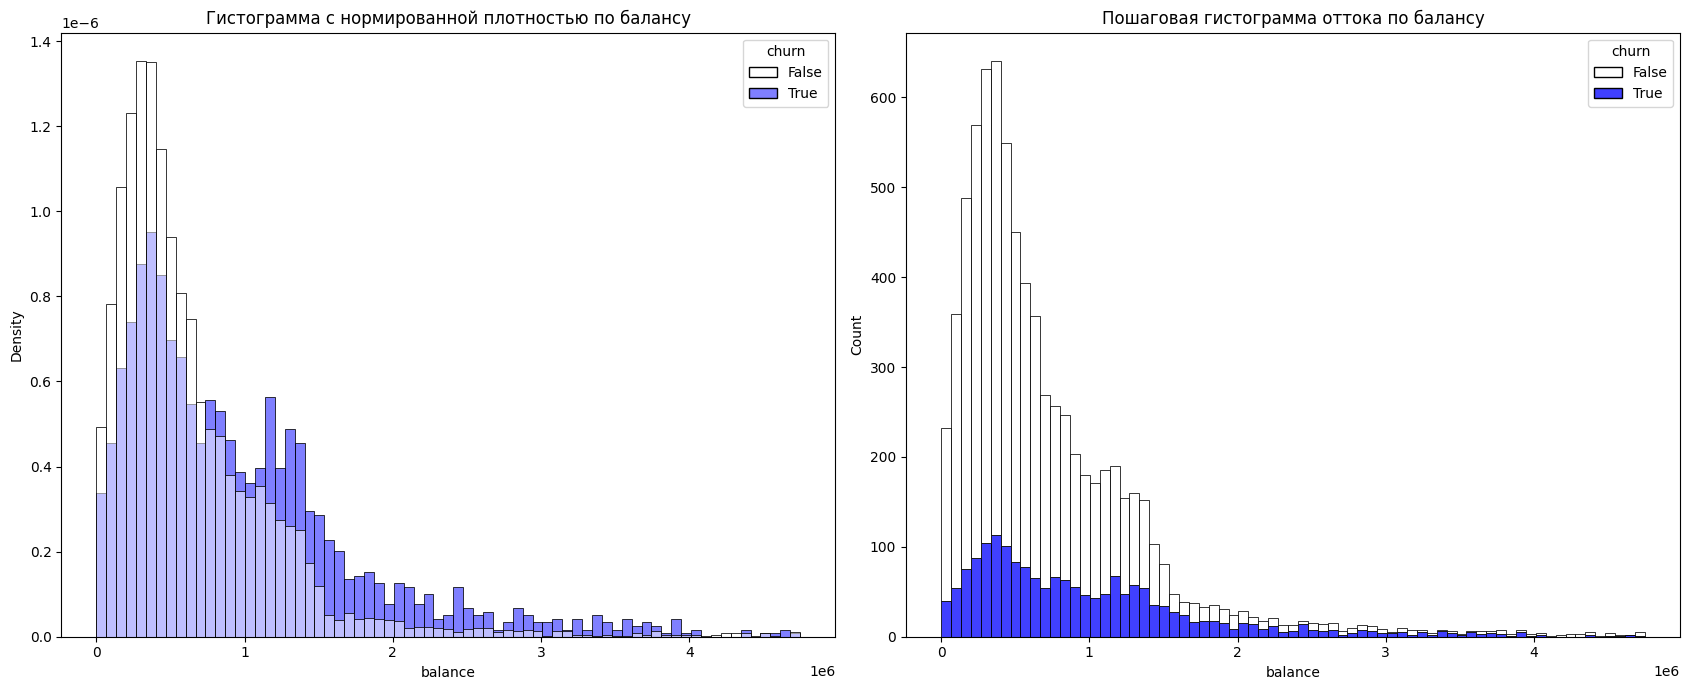

In [29]:
plot_histograms(data[data['balance'] < 4800000], x_param='balance',discreate_parametr = False,\
                title_density="Гистограмма с нормированной плотностью по балансу",\
                title_stacked="Пошаговая гистограмма оттока по балансу")

**Промежуточный вывод:** Вероятностный анализ показывает, что выско-отточные клиенты имеют баланс на счете от 800.000 до 4.000.000

### Вероятностный Анализ по количеству продуктов (`products`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


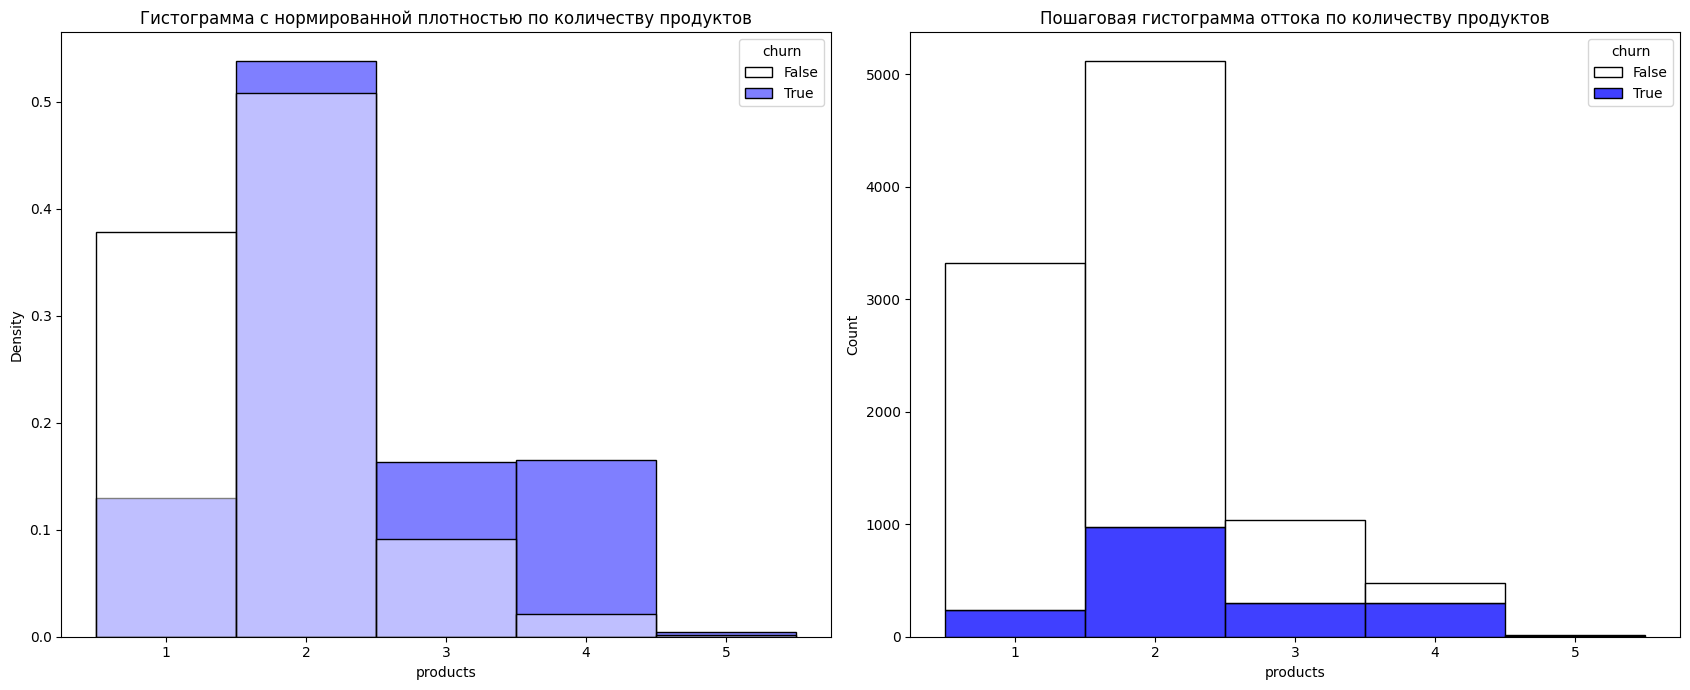

In [30]:
plot_histograms(data, x_param='products',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по количеству продуктов",\
                title_stacked="Пошаговая гистограмма оттока по количеству продуктов")

**Промежуточный вывод:** Вероятностный анализ показывает, что наиболее высоко-отточные клиенты имеют от 2 до 4 продуктов банка

### Вероятностный Анализ по наличию кредитной карты (`credit_card`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use

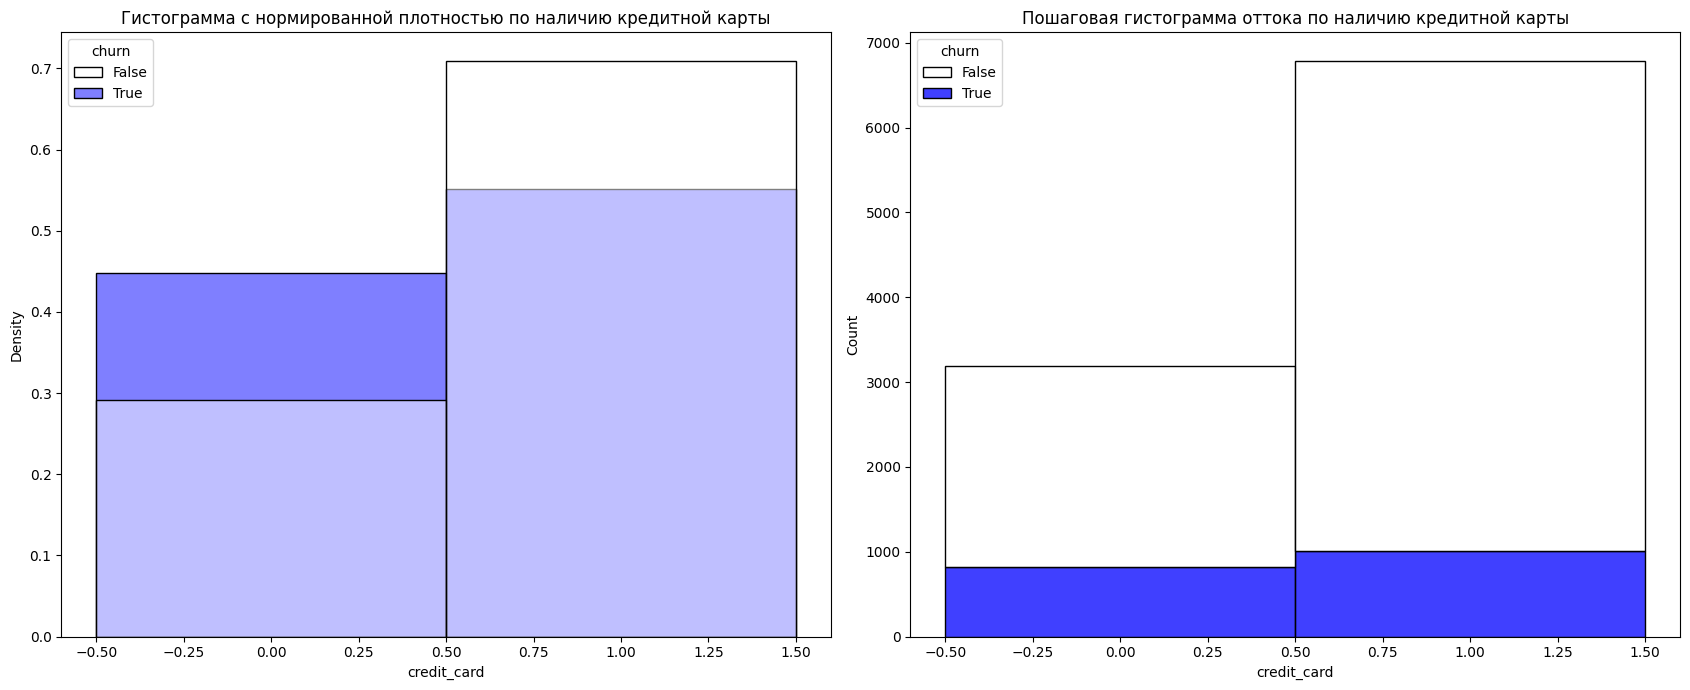

In [31]:
plot_histograms(data, x_param='credit_card',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по наличию кредитной карты",\
                title_stacked="Пошаговая гистограмма оттока по наличию кредитной карты")

**Промежуточный вывод:** Вероятностный анализ показывает, что наиболее высоко-отточные клиенты не имеют кредитных карт

### Вероятностный Анализ активности (`last_activity`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use

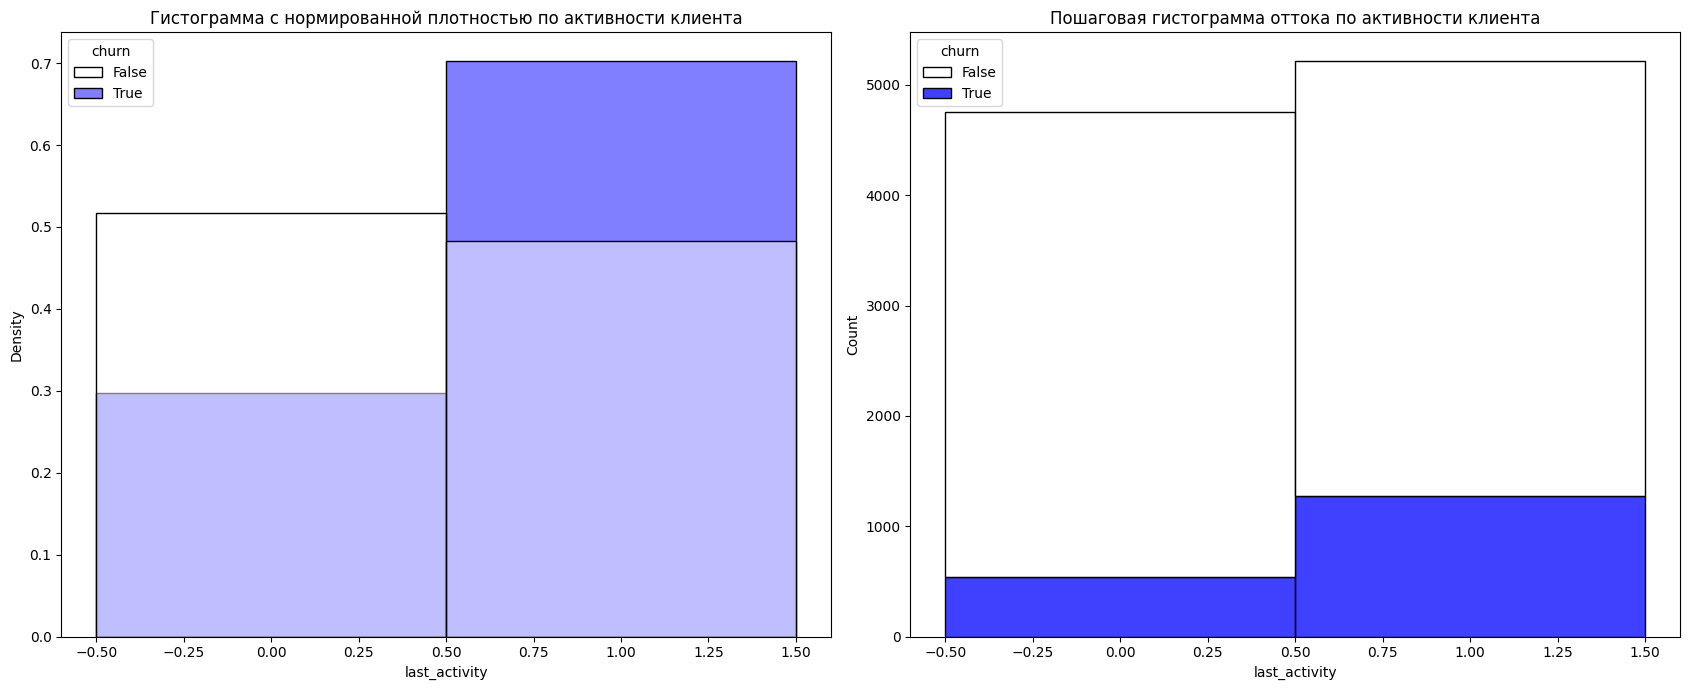

In [32]:
plot_histograms(data, x_param='last_activity',discreate_parametr = True,\
                title_density="Гистограмма с нормированной плотностью по активности клиента",\
                title_stacked="Пошаговая гистограмма оттока по активности клиента")

**Промежуточный вывод:** Вероятностный анализ показывает, что активные клиентам больше относятся к высоко-отточным

### Вероятностный Анализ по оценочному доходу клиента (`est_salary`)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


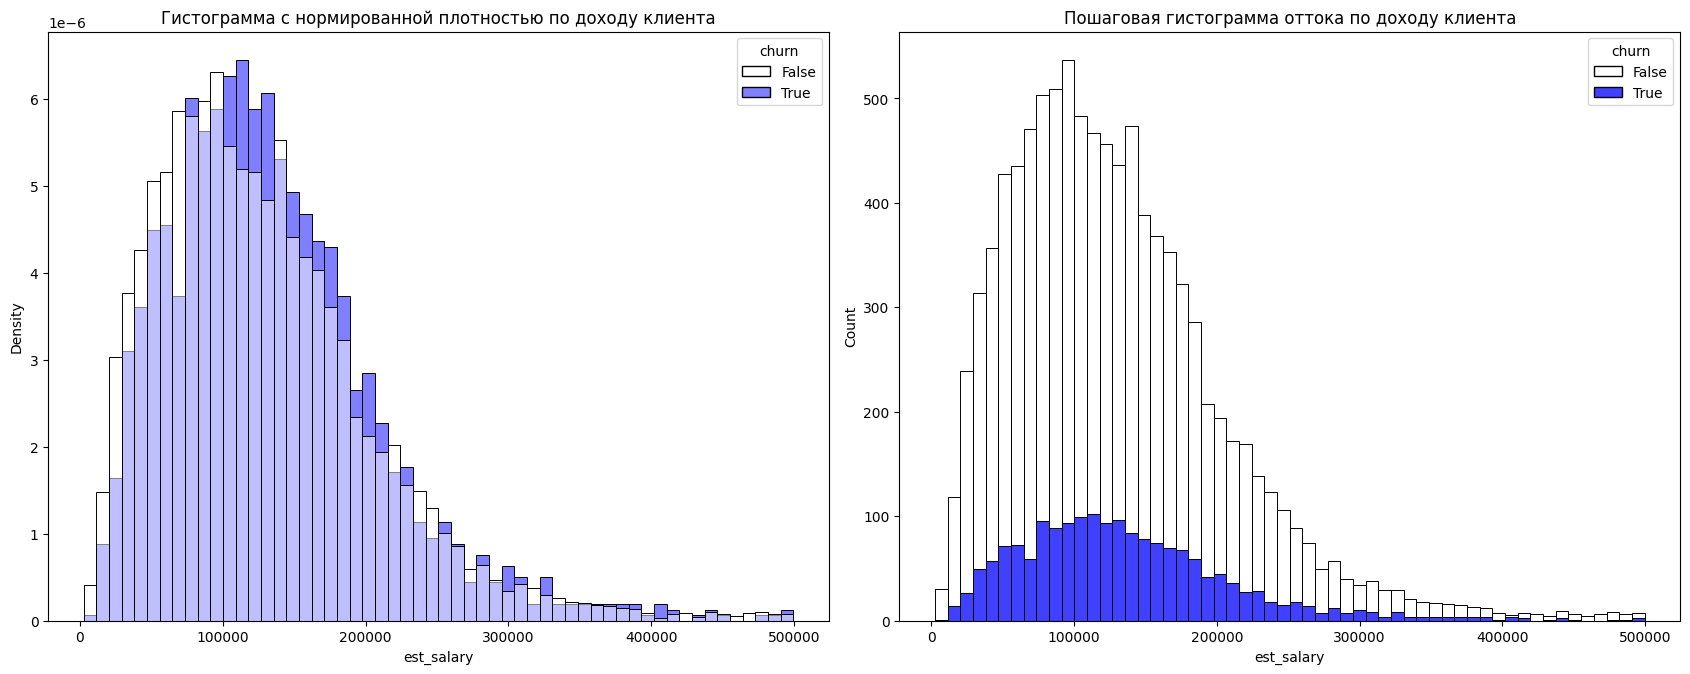

In [33]:
plot_histograms(data[data['est_salary'] <= 500000], x_param='est_salary',discreate_parametr = False,\
                title_density="Гистограмма с нормированной плотностью по доходу клиента",\
                title_stacked="Пошаговая гистограмма оттока по доходу клиента")

**Промежуточный вывод:** Вероятностный анализ оценочного дохода показывает, что более высоко-отточные клиента получают от 110.000 до 140.000 и от 160.000 до 220.000

### Корреляционный анализ

In [34]:
data_no_userid = data.drop(columns=['userid'])
corr_matrix = phik_matrix(data_no_userid) * 100
corr_matrix.round(2)

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'est_salary']


,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,100.00,9.09,7.06,3.39,52.74,17.09,41.96,20.82,5.16,39.51,22.96
city,9.09,100.00,1.18,9.15,6.26,3.99,12.53,7.46,3.05,17.08,1.67
gender,7.06,1.18,100.00,28.62,6.35,4.54,7.17,19.56,1.30,14.41,22.01
age,3.39,9.15,28.62,100.00,4.59,1.92,14.09,15.72,9.05,35.97,19.25
equity,52.74,6.26,6.35,4.59,100.00,0.00,58.33,22.14,5.11,28.55,35.21
balance,17.09,3.99,4.54,1.92,0.00,100.00,0.00,0.00,0.00,37.44,2.47
products,41.96,12.53,7.17,14.09,58.33,0.00,100.00,27.10,11.28,22.22,25.98
credit_card,20.82,7.46,19.56,15.72,22.14,0.00,27.10,100.00,4.96,3.83,20.20
last_activity,5.16,3.05,1.30,9.05,5.11,0.00,11.28,4.96,100.00,4.49,26.26
est_salary,39.51,17.08,14.41,35.97,28.55,37.44,22.22,3.83,4.49,100.00,4.90


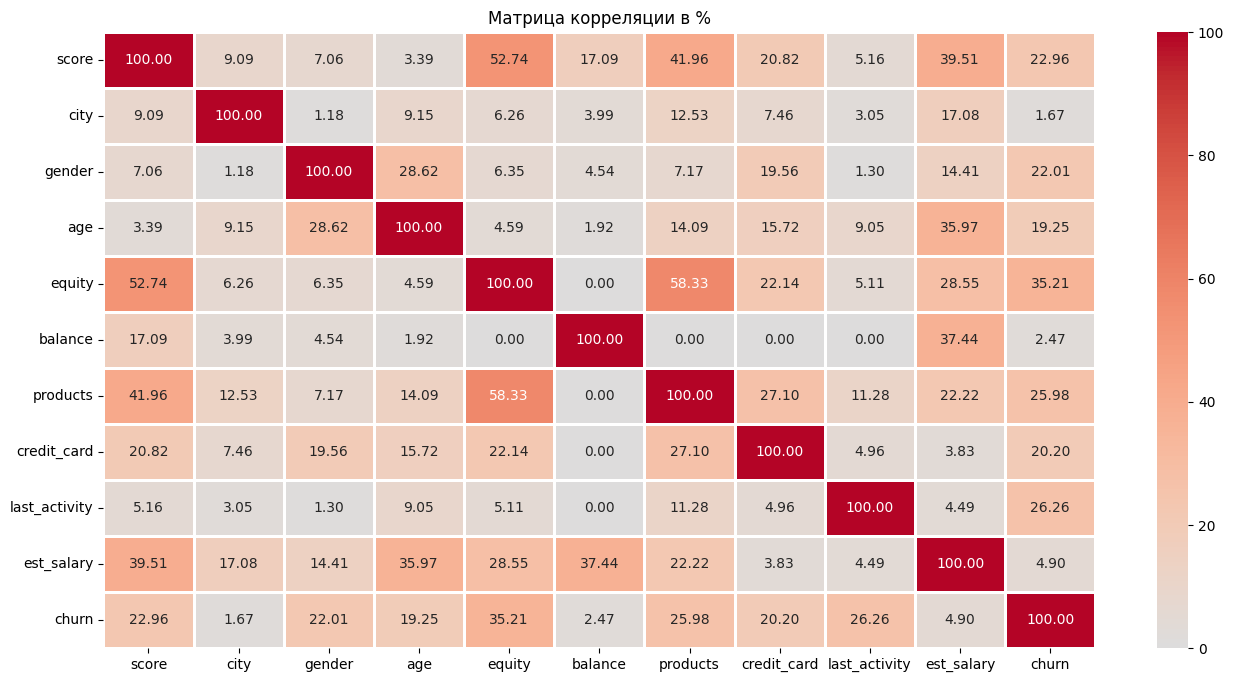

In [35]:
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix,annot=True,fmt='.2f', center = 0, cmap = 'coolwarm', linewidth=1)
plt.title('Матрица корреляции в %')
plt.show()

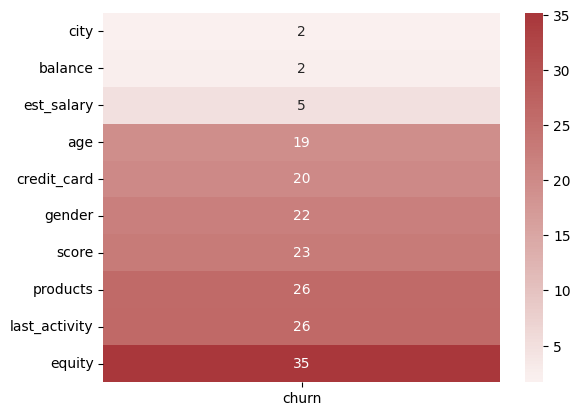

In [36]:
sns.heatmap(
    corr_matrix.loc[:,['churn']].drop('churn').sort_values('churn'),
    annot=True, fmt=".0f",cmap ="vlag", center = 0
);

**Промежуточный вывод:** Среди перечисленных переменных, активность, количество продуктов и баллов собственности имеют наиболее сильные положительные корреляции с признаком оттока. 

**Активный клиент (last_activity)**
- Коэффициент корреляции: 26.26%. Сильная положительная корреляция, что клиенты, которые реже активны, имеют более высокую вероятность покинуть сервис.

**Количество баллов собственности (equity)**
- Коэффициент корреляции: 35.21%. Положительная связь указывает на то, что клиенты с большими активами имеют большую вероятность оттока.

**Количество продуктов, которыми пользуется клиент (Products)**
- Коэффициент корреляции: 25.98%. Положительная связь указывает на то, что клиенты с большим количеством продуктов имеют большую вероятность оттока.


## Шаг 4. Проверьте статистические гипотезы

### Гипотеза о доходе: Проверьте гипотезу, что средний доход (переменная est_salary) отличается у клиентов с оттоком и без него.

Для проверки гипотезы о том, что средний доход (переменная est_salary) отличается у клиентов с оттоком и без него, можно использовать t-тест для независимых выборок

Нулевая гипотеза (H0): Средний доход клиентов с оттоком равен среднему доходу клиентов без оттока

Альтернативная гипотеза (H1): Средний доход клиентов с оттоком не равен среднему доходу клиентов без оттока

In [37]:
churn_group = data[data['churn'] == 1]['est_salary']
no_churn_group = data[data['churn'] == 0]['est_salary']

t_stat, p_value = stats.ttest_ind(churn_group, no_churn_group)

print(t_stat, p_value)

alpha = 0.05  # уровень значимости

if p_value <= alpha:
    print("\nНулевая гипотеза отклоняется: существует статистически значимая разница в среднем доходе между клиентами с оттоком и без него.")
else:
    print("\nНулевая гипотеза не отклоняется: нет статистически значимой разницы в среднем доходе между клиентами с оттоком и без него.")

0.18901074940353652 0.8500882387258035

Нулевая гипотеза не отклоняется: нет статистически значимой разницы в среднем доходе между клиентами с оттоком и без него.


**Промежуточный вывод:** Нулевая гипотеза не отклоняется: нет статистически значимой разницы в среднем доходе между клиентами с оттоком и без него.

### Гипотеза о продуктах: Проверьте, существует ли значимая разница в количестве используемых продуктов у клиентов с оттоком и без него

Для проверки гипотезы о значимости различий в количестве используемых продуктов у клиентов с оттоком и без него, мы сформулируем нулевую и альтернативную гипотезы, а затем приведем решение с использованием статистического теста.

Нулевая гипотеза (H0): Среднее количество используемых продуктов у клиентов с оттоком равно среднему количеству используемых продуктов у клиентов без оттока.

Альтернативная гипотеза (H1): Среднее количество используемых продуктов у клиентов с оттоком не равно среднему количеству используемых продуктов у клиентов без оттока.


In [38]:
churned = data[data['churn'] == True]['products']
not_churned = data[data['churn'] == False]['products']

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(churned, not_churned)

# Уровень значимости
alpha = 0.05  

# Проверка гипотезы
if p_value <= alpha:
    print("\nНулевая гипотеза отклоняется: существует статистически значимая разница в количестве используемых продуктов между клиентами с оттоком и без него.")
else:
    print("\nНулевая гипотеза не отклоняется: нет статистически значимой разницы в количестве используемых продуктов между клиентами с оттоком и без него.")


Нулевая гипотеза отклоняется: существует статистически значимая разница в количестве используемых продуктов между клиентами с оттоком и без него.


**Промежуточный вывод:** Нулевая гипотеза отклоняется: существует статистически значимая разница в количестве используемых продуктов между клиентами с оттоком и без него.

## Шаг 5. Сегментация клиентов на основе значимых признаков

### Сегментация по балансу и городу

In [39]:
bl_and_ity = data.query("balance > 750000 and balance < 4000000 and city == 'Ярославль' and (products >= 2 and products <= 4)")

In [40]:
bl_and_ity.churn.count()

1368

In [41]:
round(bl_and_ity.churn.sum() / bl_and_ity.churn.count() * 100,2)

40.94

**Промежуточный вывод:** Всего клиентов в сегменте 1338. Отток клиентов из города Ярославля с балансом от 750.000 до 4.000.000 и количеством используемых продуктов от 2 до 4 составляет 40.66%, Возможно таких клиентов следует заинтересовывать разными инвестиционными продуктами, чтобы накопив определенную сумму, клиенты оставились в банке и продолжали им пользоваться 

### Сегментация по возрасту и кредитному скорингу 

In [43]:
age_and_score = data.query("(age > 25 and age < 35) and (score > 825 and score < 940)")


In [44]:
age_and_score.churn.count()

1500

In [45]:
round(age_and_score.churn.sum() / age_and_score.churn.count() * 100,2)

29.87

**Промежуточный вывод:** Всего клиентов в сегменте 1500. Клиенты с баллами кредитного скоринга от 825 до 940 и в возрасте от 25 до 35 лет имеют процент оттока 29.87%.

In [46]:
age_and_score2 = data.query("(age > 50 and age < 60) and (score > 825 and score < 940)")

In [47]:
age_and_score2.churn.count()

811

In [48]:
round(age_and_score2.churn.sum() / age_and_score2.churn.count() * 100,2)

32.68

**Промежуточный вывод:** Всего клиентов в сегменте 811. Клиенты с баллами кредитного скоринга от 825 до 940 и в возрасте от 50 до 60 лет имеют процент оттока 32.68%. 

**Общая рекомендация:** 

Понимание потребностей клиентов: Проведение опросов и фокус-групп для выявления причин оттока и понимания ожиданий клиентов.

Целевые маркетинговые стратегии: Разработка специальных предложений и программ лояльности, учитывающих особенности каждой возрастной группы.

### Сегментация по оценочному доходу и наличию кредитной карты 

In [49]:
est_salary_and_credit_card = data.query("(est_salary > 110000 and age < 140000) and (credit_card == False)")

In [50]:
est_salary_and_credit_card.churn.count()

1718

In [51]:
round(est_salary_and_credit_card.churn.sum() / est_salary_and_credit_card.churn.count() * 100,2)

29.69

**Промежуточный вывод:** Всего клиентов в сегменте 1718. Клиенты с высоким доходом от 110.000 до 140.000 без кредитной карты имеют процент оттока 29.69%

In [52]:
est_salary_and_credit_card2 = data.query("(est_salary > 160000 and age < 220000) and (credit_card == False)")

In [53]:
est_salary_and_credit_card2.churn.count()

939

In [54]:
round(est_salary_and_credit_card2.churn.sum() / est_salary_and_credit_card2.churn.count() * 100,2)

31.2

**Промежуточный вывод:** Всего клиентов в сегменте 939. Клиенты с высоким доходом от 160.000 до 220.000 без кредитной карты имеют процент оттока 31.2%

**Общая рекомендация:** Возможно стоит предложить клиентам без кредитной карты обзавестись ей, потому что клиенты с высоким доходом и наличием кредитной карты: могут быть заинтересованы в премиум-продуктах и эксклюзивных предложениях.

### Сегментация по активному клиенту мужчине и количеству баллов собственности

In [55]:
last_activity_men_and_equity = data.query("(gender == 'М') and (equity >= 3 and equity <= 7) and (last_activity == 1)")

In [56]:
last_activity_men_and_equity.churn.count()

1399

In [57]:
round(last_activity_men_and_equity.churn.sum() / last_activity_men_and_equity.churn.count() * 100,2)

45.96

**Промежуточный вывод:** Всего клиентов в сегменте 1399. У активных клиентов мужчин с количеством баллов собственности от 3 до 7 процент оттока состовляет 45.96%

**Рекомендация:** Создание индивидуальных предложений на основе предпочтений клиентов. Например, предоставление скидок на какие-то продукты, которыми они часто используют.
Преимущества: Персонализированный подход повышает лояльность и демонстрирует клиентам, что их ценят.

## Общий вывод: 

**Общий отток пользователй** составил 18.23% 

#### Вероятностный анализ

- Для баллов кредитного скоринга высоко-отточные значения расположены примерно в пределах от 825 до 940 баллов

- Вероятностный анализ показывает, что в городе Ярославоль более высокий отток пользователей, чем в остальных городах

- Вероятностный анализ показывет, что мужчины больше склонны к оттоку

- Вероятностный анализ показывет, что высоко-отточные значения возраста клиентов расположены в пределах от 25 до 35 лет и от 50 года до 60 лет

- Вероятностный анализ показывает, что высоко-отточные клиенты расположены в пределах от 3 до 6 баллов собственности 

- Вероятностный анализ показывает, что выско-отточные клиенты имеют баланс на счете от 800.000 до 4.000.000

- Вероятностный анализ показывает, что наиболее высоко-отточные клиенты имеют от 2 до 4 продуктов банка

- Вероятностный анализ показывает, что наиболее высоко-отточные клиенты не имеют кредитных карт

- Вероятностный анализ показывает, что активные клиентам больше относятся к высоко-отточным

- Вероятностный анализ оценочного дохода показывает, что более высоко-отточные клиента получают от 110.000 до 140.000 и от 160.000 до 220.000

#### Построив матрицу корреляции среди перечисленных переменных, активность, количество продуктов и баллов собственности имеют наиболее сильные положительные корреляции с признаком оттока. 

**Активный клиент (last_activity)**
- Коэффициент корреляции: 26.26%. Сильная положительная корреляция, что клиенты, которые реже активны, имеют более высокую вероятность покинуть сервис.

**Количество баллов собственности (equity)**
- Коэффициент корреляции: 35.21%. Положительная связь указывает на то, что клиенты с большими активами имеют большую вероятность оттока.

**Количество продуктов, которыми пользуется клиент (Products)**
- Коэффициент корреляции: 25.98%. Положительная связь указывает на то, что клиенты с большим количеством продуктов имеют большую вероятность оттока.


#### Гипотеза о доходе: Cредний доход (переменная est_salary) отличается у клиентов с оттоком и без него.
- Вывод: нет статистически значимой разницы в среднем доходе между клиентами с оттоком и без него.


#### Гипотеза о продуктах: Cуществует ли значимая разница в количестве используемых продуктов у клиентов с оттоком и без него. 
- Вывод: существует статистически значимая разница в количестве используемых продуктов между клиентами с оттоком и без него.

#### Сегментация по балансу и городу

- Всего клиентов в сегменте 1338. Отток клиентов из города Ярославля с балансом от 750.000 до 4.000.000 и количеством используемых продуктов от 2 до 4 составляет 40.66%, Возможно таких клиентов следует заинтересовывать разными инвестиционными продуктами, чтобы накопив определенную сумму, клиенты остались в банке и продолжали им пользоваться


#### Сегментация по возрасту и кредитному скорингу

- Всего клиентов в сегменте 1500. Клиенты с баллами кредитного скоринга от 825 до 940 и в возрасте от 25 до 35 лет имеют процент оттока 29.87%.

- Всего клиентов в сегменте 811. Клиенты с баллами кредитного скоринга от 825 до 940 и в возрасте от 50 до 60 лет имеют процент оттока 32.68%.

- Общая рекомендация:Понимание потребностей клиентов: Проведение опросов и фокус-групп для выявления причин оттока и понимания ожиданий клиентов.Целевые маркетинговые стратегии: Разработка специальных предложений и программ лояльности, учитывающих особенности каждой возрастной группы.


#### Сегментация по оценочному доходу и наличию кредитной карты

- Всего клиентов в сегменте 1718. Клиенты с высоким доходом от 110.000 до 140.000 без кредитной карты имеют процент оттока 29.69%

- Всего клиентов в сегменте 939. Клиенты с высоким доходом от 160.000 до 220.000 без кредитной карты имеют процент оттока 31.2%

- Общая рекомендация: Возможно стоит предложить клиентам без кредитной карты обзавестись ей, потому что клиенты с высоким доходом и наличием кредитной карты: могут быть заинтересованы в премиум-продуктах и эксклюзивных предложениях.

#### Сегментация по активному клиенту мужчине и количеству баллов собственности

- Всего клиентов в сегменте 1399. У активных клиентов мужчин с количеством баллов собственности от 3 до 7 процент оттока состовляет 45.96%

- Рекомендация: Создание индивидуальных предложений на основе предпочтений клиентов. Например, предоставление скидок на какие-то продукты, которыми они часто используют. Преимущества: Персонализированный подход повышает лояльность и демонстрирует клиентам, что их ценят.






## Проект для яндекс практикума
### Материалы
* .[Презентация](https://disk.yandex.ru/d/PVst4l-UkpSqGg)